In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import time
from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis, LocalOutlierFactor
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

/kaggle/input/breast-cancer-wisconsin-data/data.csv
breast-cancer-wisconsin-data



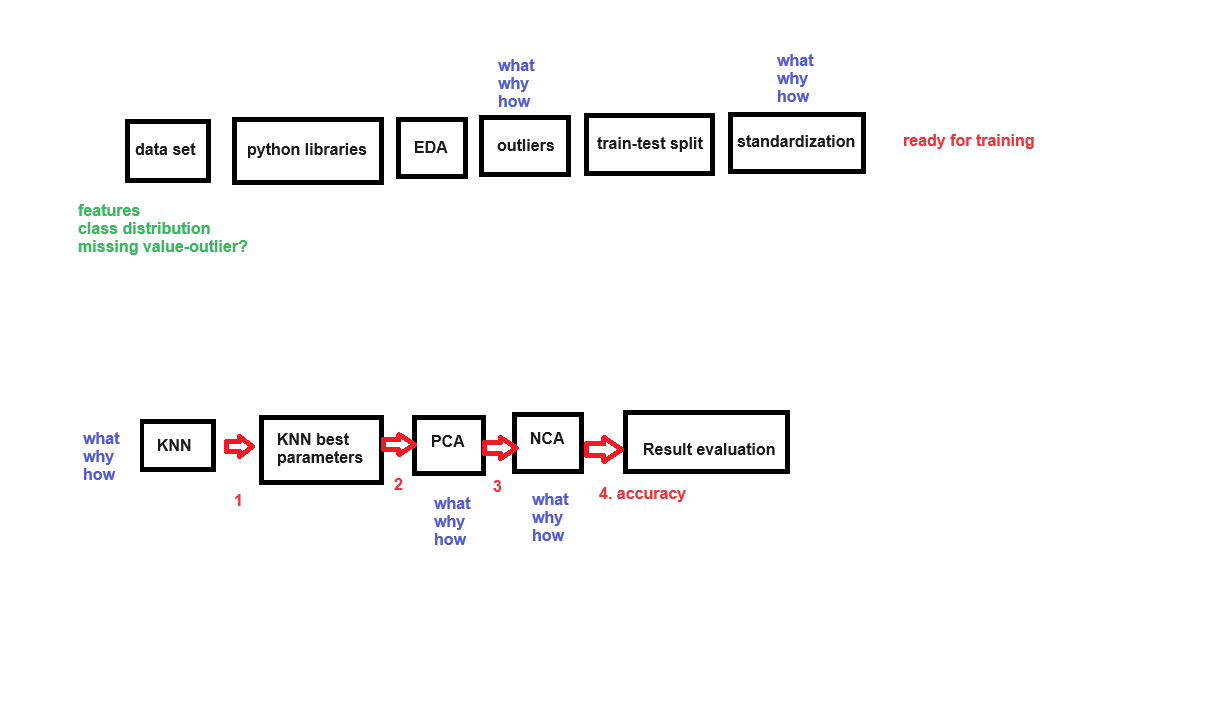

In [2]:
data = pd.read_csv('../input/breast-cancer-wisconsin-data/data.csv')

In [3]:
data

id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0      842302         M        17.99         10.38          122.80     1001.0   
1      842517         M        20.57         17.77          132.90     1326.0   
2    84300903         M        19.69         21.25          130.00     1203.0   
3    84348301         M        11.42         20.38           77.58      386.1   
4    84358402         M        20.29         14.34          135.10     1297.0   
..        ...       ...          ...           ...             ...        ...   
564    926424         M        21.56         22.39          142.00     1479.0   
565    926682         M        20.13         28.25          131.20     1261.0   
566    926954         M        16.60         28.08          108.30      858.1   
567    927241         M        20.60         29.33          140.10     1265.0   
568     92751         B         7.76         24.54           47.92      181.0   

     smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0            0.11840           0.27760         0.30010              0.14710   
1            0.08474           0.07864         0.08690              0.07017   
2            0.10960           0.15990         0.19740              0.12790   
3            0.14250           0.28390         0.24140              0.10520   
4            0.10030           0.13280         0.19800              0.10430   
..               ...               ...             ...                  ...   
564          0.11100           0.11590         0.24390              0.13890   
565          0.09780           0.10340         0.14400              0.09791   
566          0.08455           0.10230         0.09251              0.05302   
567          0.11780           0.27700         0.35140              0.15200   
568          0.05263           0.04362         0.00000              0.00000   

     ...  texture_worst  perimeter_worst  area_worst  smoothness_worst  \
0    ...          17.33           184.60      2019.0           0.16220   
1    ...          23.41           158.80      1956.0           0.12380   
2    ...          25.53           152.50      1709.0           0.14440   
3    ...          26.50            98.87       567.7           0.20980   
4    ...          16.67           152.20      1575.0           0.13740   
..   ...            ...              ...         ...               ...   
564  ...          26.40           166.10      2027.0           0.14100   
565  ...          38.25           155.00      1731.0           0.11660   
566  ...          34.12           126.70      1124.0           0.11390   
567  ...          39.42           184.60      1821.0           0.16500   
568  ...          30.37            59.16       268.6           0.08996   

     compactness_worst  concavity_worst  concave points_worst  symmetry_worst  \
0              0.66560           0.7119                0.2654          0.4601   
1              0.18660           0.2416                0.1860          0.2750   
2              0.42450           0.4504                0.2430          0.3613   
3              0.86630           0.6869                0.2575          0.6638   
4              0.20500           0.4000                0.1625          0.2364   
..                 ...              ...                   ...             ...   
564            0.21130           0.4107                0.2216          0.2060   
565            0.19220           0.3215                0.1628          0.2572   
566            0.30940           0.3403                0.1418          0.2218   
567            0.86810           0.9387                0.2650          0.4087   
568            0.06444           0.0000                0.0000          0.2871   

     fractal_dimension_worst  Unnamed: 32  
0                    0.11890          NaN  
1                    0.08902          NaN  
2                    0.08758          NaN  
3                    0.17300          NaN  
4      

In [4]:
data.drop(["Unnamed: 32","id"], inplace=True, axis=1)

In [5]:
data = data.rename(columns = {"diagnosis" : "target"})

In [6]:
data["target"] = [1 if i.strip() == "M" else 0 for i in data.target]

target
0    357
1    212
Name: count, dtype: int64


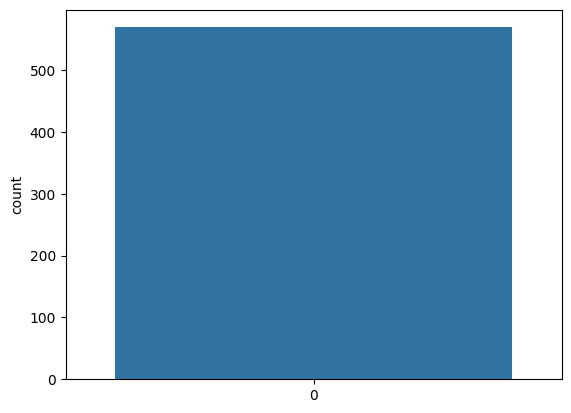

In [7]:
sns.countplot(data["target"], label="Count")
print(data.target.value_counts())

In [8]:
data.shape

(569, 31)

In [9]:
data.info() #missing value bulmak için kullanılabilir ama burada yok

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   target                   569 non-null    int64  
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

In [10]:
data.describe().T #bazı veriler arasında büyük farklar olduğu için standardization yapılacak

count        mean         std         min  \
target                   569.0    0.372583    0.483918    0.000000   
radius_mean              569.0   14.127292    3.524049    6.981000   
texture_mean             569.0   19.289649    4.301036    9.710000   
perimeter_mean           569.0   91.969033   24.298981   43.790000   
area_mean                569.0  654.889104  351.914129  143.500000   
smoothness_mean          569.0    0.096360    0.014064    0.052630   
compactness_mean         569.0    0.104341    0.052813    0.019380   
concavity_mean           569.0    0.088799    0.079720    0.000000   
concave points_mean      569.0    0.048919    0.038803    0.000000   
symmetry_mean            569.0    0.181162    0.027414    0.106000   
fractal_dimension_mean   569.0    0.062798    0.007060    0.049960   
radius_se                569.0    0.405172    0.277313    0.111500   
texture_se               569.0    1.216853    0.551648    0.360200   
perimeter_se             569.0    2.866059    2.021855    0.757000   
area_se                  569.0   40.337079   45.491006    6.802000   
smoothness_se            569.0    0.007041    0.003003    0.001713   
compactness_se           569.0    0.025478    0.017908    0.002252   
concavity_se             569.0    0.031894    0.030186    0.000000   
concave points_se        569.0    0.011796    0.006170    0.000000   
symmetry_se              569.0    0.020542    0.008266    0.007882   
fractal_dimension_se     569.0    0.003795    0.002646    0.000895   
radius_worst             569.0   16.269190    4.833242    7.930000   
texture_worst            569.0   25.677223    6.146258   12.020000   
perimeter_worst          569.0  107.261213   33.602542   50.410000   
area_worst               569.0  880.583128  569.356993  185.200000   
smoothness_worst         569.0    0.132369    0.022832    0.071170   
compactness_worst        569.0    0.254265    0.157336    0.027290   
concavity_worst          569.0    0.272188    0.208624    0.000000   
concave points_worst     569.0    0.114606    0.065732    0.000000   
symmetry_worst           569.0    0.290076    0.061867    0.156500   
fractal_dimension_worst  569.0    0.083946    0.018061    0.055040   

                                25%         50%          75%         max  
target                     0.000000    0.000000     1.000000     1.00000  
radius_mean               11.700000   13.370000    15.780000    28.11000  
texture_mean              16.170000   18.840000    21.800000    39.28000  
perimeter_mean            75.170000   86.240000   104.100000   188.50000  
area_mean                420.300000  551.100000   782.700000  2501.00000  
smoothness_mean            0.086370    0.095870     0.105300     0.16340  
compactness_mean           0.064920    0.092630     0.130400     0.34540  
concavity_mean             0.029560    0.061540     0.130700     0.42680  
concave points_mean        0.020310    0.033500     0.074000     0.20120  
symmetry_mean              0.161900    0.179200     0.195700     0.30400  
fractal_dimension_mean     0.057700    0.061540     0.066120     0.09744  
radius_se                  0.232400    0.324200     0.478900     2.87300  
texture_se                 0.833900    1.108000     1.474000     4.88500  
perimeter_se               1.606000    2.287000     3.357000    21.98000  
area_se                   17.850000   24.530000    45.190000   542.20000  
smoothness_se              0.005169    0.006380     0.008146     0.03113  
compactness_se             0.013080    0.020450     0.032450     0.13540  
concavity_se               0.015090    0.025890     0.042050     0.39600  
concave points_se          0.007638    0.010930     0.014710     0.05279  
symmetry_se                0.015160    0.018730     0.023480     0.07895  
fractal_dimension_se       0.002248    0.003187     0.004558     0.02984  
radius_worst              13.010000   14.970000    18.790000    36.04000  
texture_worst             21.080000   25.410000    29.72000

### EDA

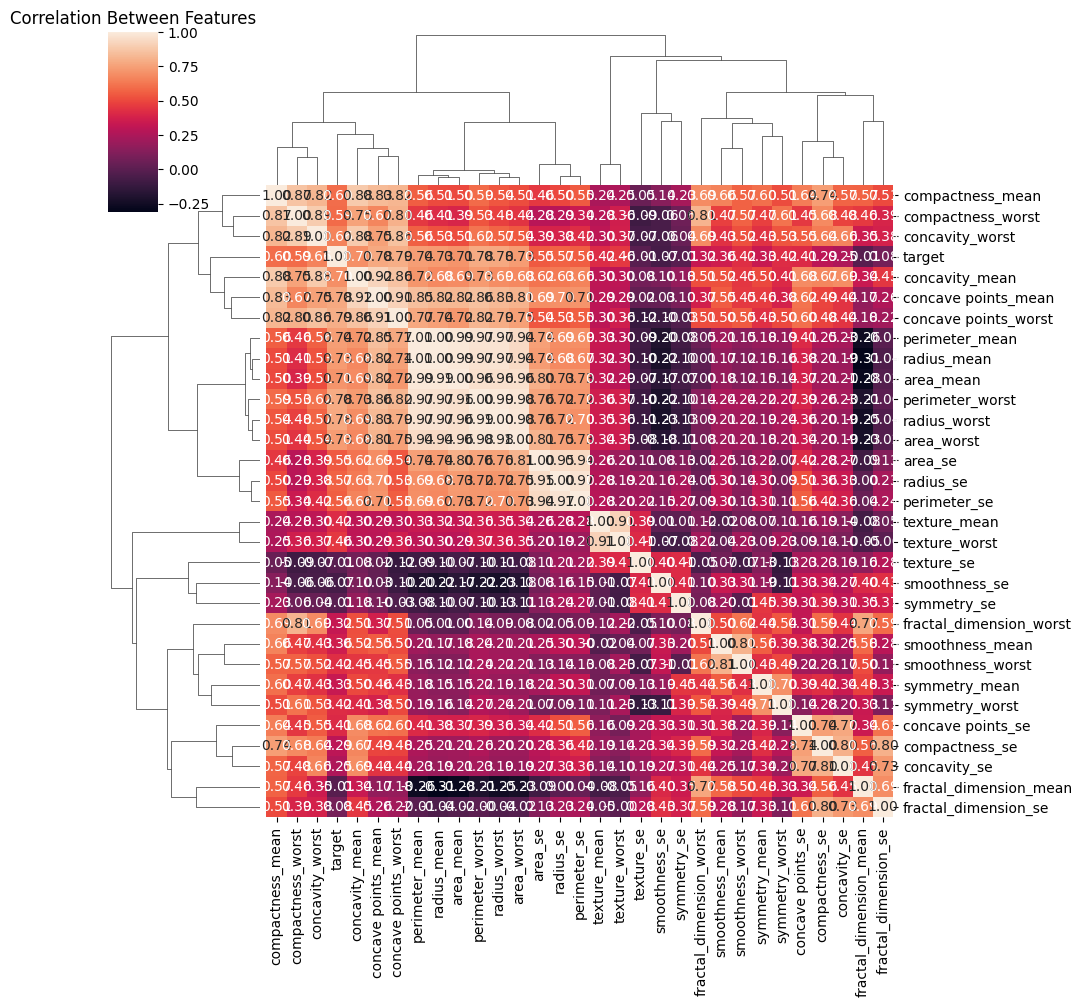

In [11]:
#correlation
corr_matrix = data.corr()
sns.clustermap(corr_matrix, annot=True, fmt  = ".2f")
plt.title("Correlation Between Features")
plt.show()

In [12]:
# ML modelinde çeşitlilik dikkat edilmeli, korelasyonu az olan featurelar

Text(0.5, 1.0, 'Correlation Between Features with Corr Threshold 0.75')

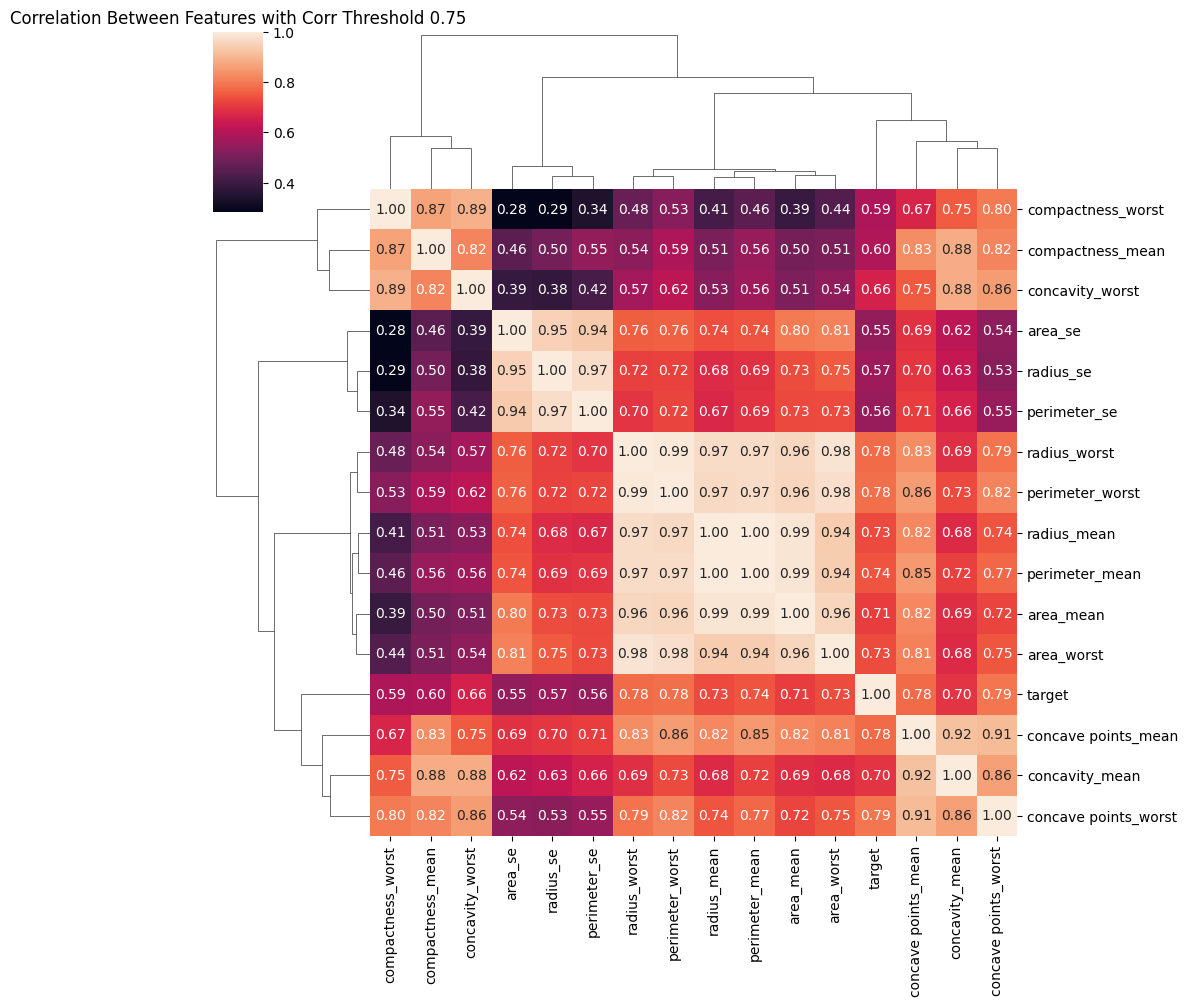

In [13]:
threshold = 0.5
filtre = np.abs(corr_matrix["target"]) > threshold
corr_features = corr_matrix.columns[filtre].tolist()
sns.clustermap(data[corr_features].corr(), annot=True, fmt  = ".2f")
plt.title("Correlation Between Features with Corr Threshold 0.75")

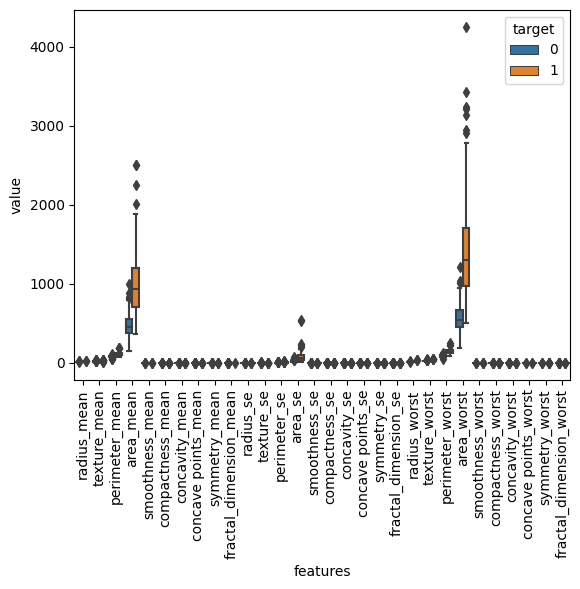

In [14]:
data_melted = pd.melt(data, id_vars = "target",
                     var_name = "features",
                      value_name = "value")
plt.figure()
sns.boxplot(x="features", y="value", hue="target", data=data_melted)
plt.xticks(rotation=90)
plt.show()
#anlamlı gözükmesi için normalization-standardization

In [15]:
corr_features

['target',
 'radius_mean',
 'perimeter_mean',
 'area_mean',
 'compactness_mean',
 'concavity_mean',
 'concave points_mean',
 'radius_se',
 'perimeter_se',
 'area_se',
 'radius_worst',
 'perimeter_worst',
 'area_worst',
 'compactness_worst',
 'concavity_worst',
 'concave points_worst']

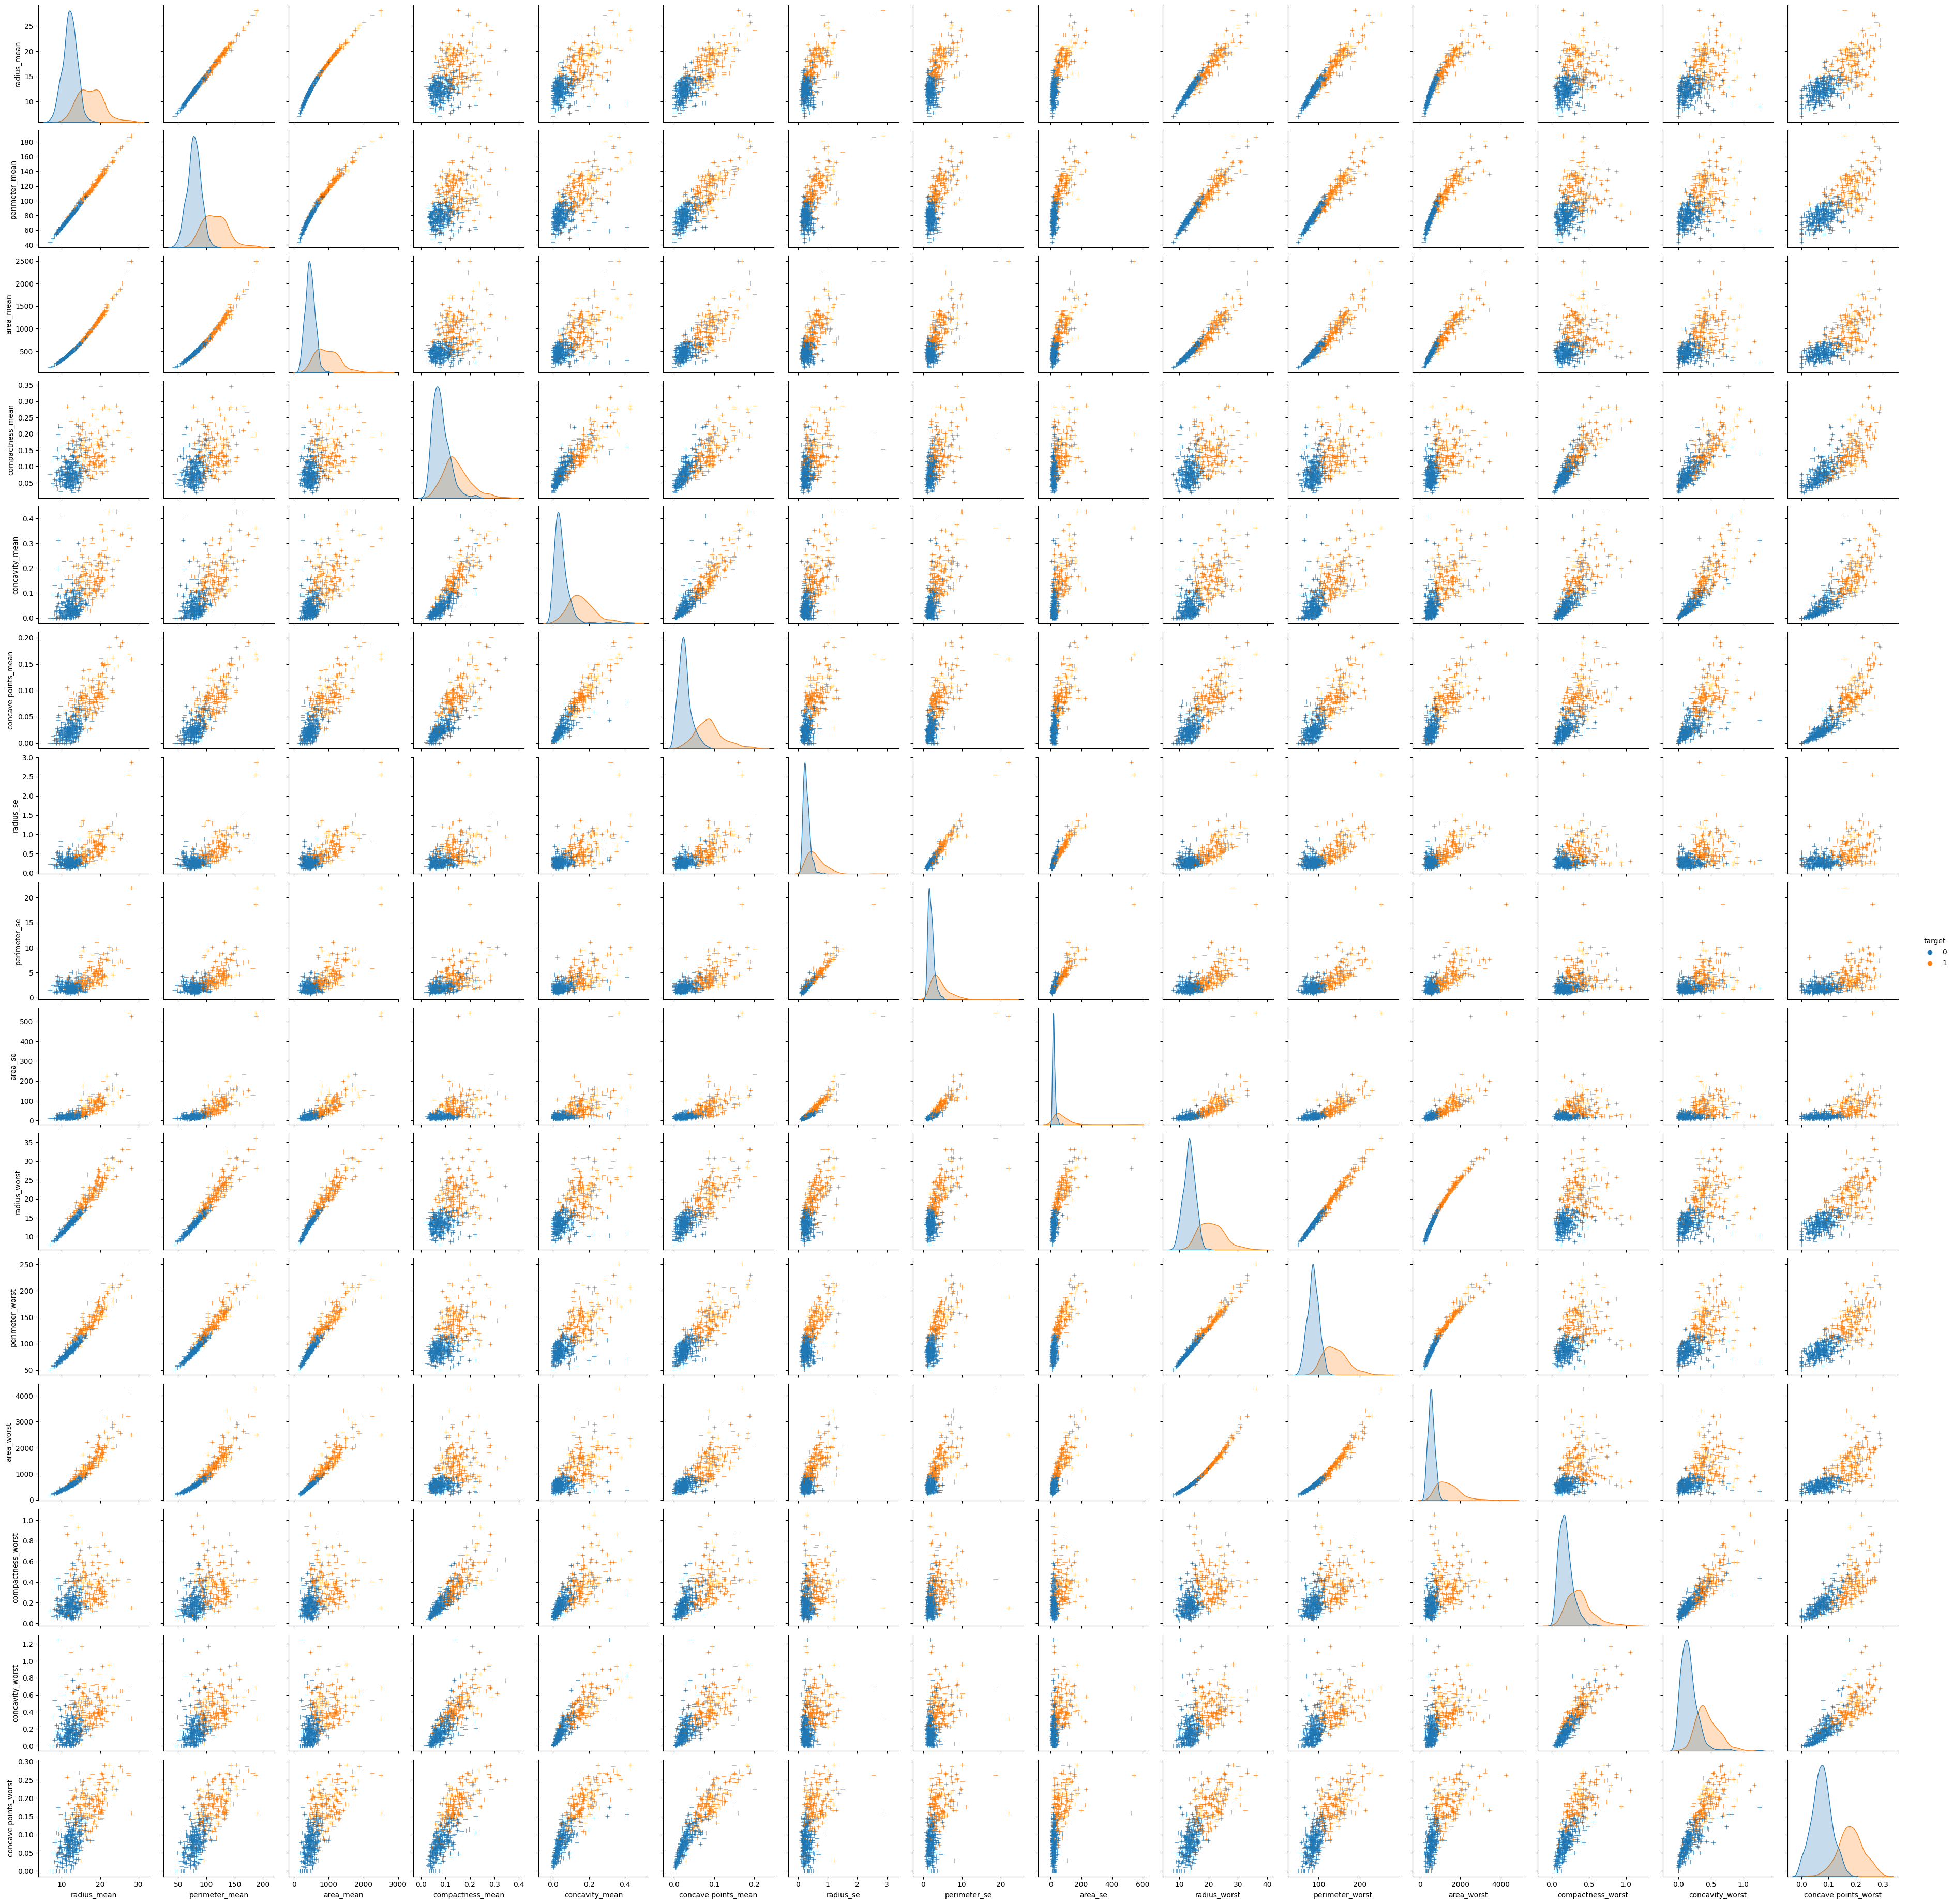

In [16]:
sns.pairplot(data[corr_features], diag_kind = "kde", markers="+", hue = "target")
plt.show()

In [17]:
# normal distribution yoksa (+, - skewness) outlier çıkarılabilir
# positive skewness ta mean sağda, -' te solda

### Outliers

In [18]:
# density based Outlier Detection system --> LOF, skew data için etkili
# compare local density of one point to local density of its KNN

In [19]:
y = data.target
x = data.drop(["target"], axis=1)
columns = x.columns.tolist()

In [20]:
y

0      1
1      1
2      1
3      1
4      1
      ..
564    1
565    1
566    1
567    1
568    0
Name: target, Length: 569, dtype: int64

In [21]:
columns

['radius_mean',
 'texture_mean',
 'perimeter_mean',
 'area_mean',
 'smoothness_mean',
 'compactness_mean',
 'concavity_mean',
 'concave points_mean',
 'symmetry_mean',
 'fractal_dimension_mean',
 'radius_se',
 'texture_se',
 'perimeter_se',
 'area_se',
 'smoothness_se',
 'compactness_se',
 'concavity_se',
 'concave points_se',
 'symmetry_se',
 'fractal_dimension_se',
 'radius_worst',
 'texture_worst',
 'perimeter_worst',
 'area_worst',
 'smoothness_worst',
 'compactness_worst',
 'concavity_worst',
 'concave points_worst',
 'symmetry_worst',
 'fractal_dimension_worst']

In [22]:
clf = LocalOutlierFactor()
y_pred = clf.fit_predict(x) #-1 outlier, 1 not outlier

In [23]:
X_score = clf.negative_outlier_factor_

In [24]:
outlier_score = pd.DataFrame()
outlier_score["score"] = X_score
X_score

array([-1.42244008, -1.06678249, -0.97894764, -1.59693295, -1.06993589,
       -1.773071  , -1.01568723, -1.25174625, -1.38051485, -1.64435685,
       -0.99760184, -1.06178607, -1.12949091, -1.25844429, -0.96863713,
       -1.09335084, -1.13938097, -1.06049329, -1.41067136, -0.97224755,
       -0.98172267, -1.01796076, -1.00120872, -1.55647306, -1.76479918,
       -1.14444971, -1.18253923, -1.05669361, -1.1171278 , -0.96612603,
       -0.98190689, -1.99760079, -1.00701649, -1.00581116, -1.01466535,
       -0.98769018, -0.98362673, -1.39411328, -2.2334333 , -1.09045555,
       -1.14776543, -1.31502499, -0.98035055, -1.4174209 , -1.28342864,
       -0.98156833, -1.32235455, -1.32568003, -1.09322188, -0.97065701,
       -0.97278561, -1.05918996, -0.97370459, -1.02944   , -1.03748568,
       -1.00072293, -1.24017071, -1.05450437, -0.99159205, -1.09401411,
       -0.98594633, -1.09659782, -1.08187925, -1.00799336, -1.59848383,
       -1.05245105, -1.02666387, -0.97040029, -1.01252311, -1.06

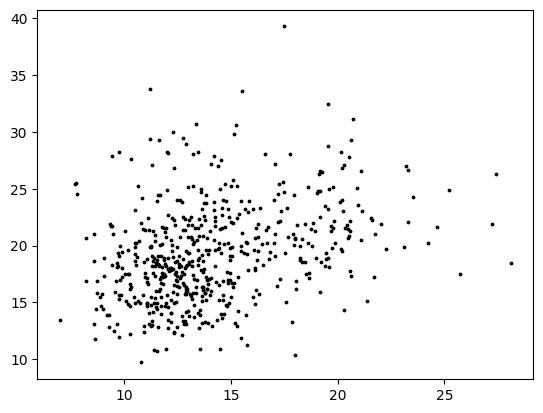

In [25]:
plt.figure()
plt.scatter(x.iloc[:, 0],x.iloc[:, 1], color="k", s=3, label="Data Points" )# ilk ve ikinci sütun

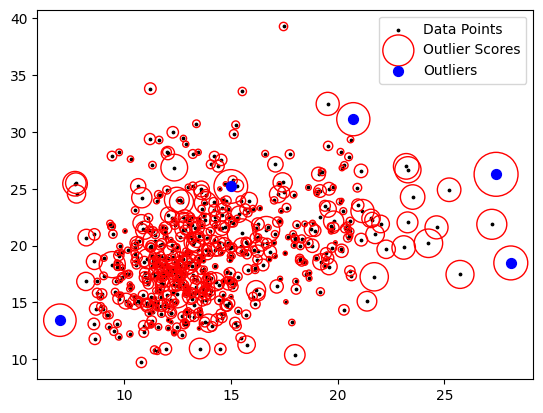

In [26]:
plt.figure()
plt.scatter(x.iloc[:, 0],x.iloc[:, 1], color="k", s=3, label="Data Points" )# ilk ve ikinci sütun
radius = (X_score.max() - X_score) / (X_score.max() - X_score.min()) #normalization
outlier_score["radius"] = radius
plt.scatter(x.iloc[:, 0],x.iloc[:, 1], edgecolors="r", facecolors = "none", s=1000*radius, label="Outlier Scores" )
threshold = -2
filtre = outlier_score["score"] < threshold
outlier_index = outlier_score[filtre].index.tolist()
plt.scatter(x.iloc[outlier_index, 0],x.iloc[outlier_index, 1], color="blue", s=50, label="Outliers" )
plt.legend()
plt.show()

In [27]:
#drop outliers
x = x.drop(outlier_index) # dataframe
y = y.drop(outlier_index).values # array a çevirdik

### Train-test_split

In [28]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [29]:
X_train.shape

(394, 30)

In [30]:
X_test.shape

(170, 30)

### Standardization
* Verinin yeniden ölçeklendirilmesi --> ilk verinin mean=3, std=1.5 olsun,
x-M/std = verinin std' si 1 olur. bu işlemi yapmak için normal koşullarda gaussian dağılıma sahip olması lazım.


In [31]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) 
X_test = scaler.transform(X_test) # test için fit etmiyoruz

In [32]:
X_train_df = pd.DataFrame(X_train, columns=columns)

In [33]:
X_train_df

radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  \
0      -0.341501     -0.763712       -0.333129  -0.402012        -0.656703   
1      -1.038477     -0.128318       -1.040263  -0.926658         0.741259   
2      -0.948825      0.667695       -0.959412  -0.851161        -0.570159   
3      -1.276490     -0.156663       -1.265222  -1.059958        -0.468959   
4      -0.156413     -1.132193       -0.177292  -0.242466         0.112421   
..           ...           ...             ...        ...              ...   
389     0.902065      1.267658        0.942895   0.828354         0.762197   
390     2.368317      0.122060        2.559920   2.537655         2.541930   
391     1.113182      1.258209        0.984787   1.033317        -0.532471   
392    -0.017596     -0.825126       -0.088062  -0.123912        -1.152934   
393    -1.038477      0.032301       -1.017223  -0.921350         0.258987   

     compactness_mean  concavity_mean  concave points_mean  symmetry_mean  \
0           -0.189561       -0.507837            -0.463354      -0.106630   
1           -0.727209       -0.832293            -0.799738      -1.186957   
2           -0.904779       -0.667753            -0.896436       0.762011   
3           -0.806973       -0.750960            -0.868147       1.572256   
4           -0.451643       -0.286702            -0.027957       0.283893   
..                ...             ...                  ...            ...   
389          1.479979        0.994630             0.785486       0.437183   
390          3.261378        4.207956             3.430785       2.732877   
391         -0.660929       -0.407264            -0.037473      -0.982571   
392         -0.935545       -0.858529            -0.575482      -0.796433   
393         -0.366371       -0.745088            -0.948642       1.495611   

     fractal_dimension_mean  ...  radius_worst  texture_worst  \
0                 -0.094194  ...     -0.369298      -0.611776   
1                  0.418254  ...     -1.096715      -0.166392   
2                 -0.456418  ...     -0.735133       1.061690   
3                  0.155712  ...     -1.079699       0.010452   
4                 -0.752655  ...     -0.235300      -1.030961   
..                      ...  ...           ...            ...   
389                0.259606  ...      1.510926       1.353155   
390                1.034596  ...      2.591416       0.401801   
391               -1.112071  ...      1.000458       1.495612   
392               -1.005369  ...     -0.277839      -1.022774   
393                0.251182  ...     -0.994621      -0.367797   

     perimeter_worst  area_worst  smoothness_worst  compactness_worst  \
0          -0.299193   -0.418930         -0.059154          -0.020998   
1          -1.108509   -0.917309          0.368999          -0.998500   
2          -0.712278   -0.705442         -0.097307          -0.574743   
3          -1.104832   -0.899111         -0.389808          -0.674833   
4          -0.221663   -0.293779          0.483456          -0.524698   
..               ...         ...               ...                ...   
389         1.368777    1.506994          1.098132           3.128584   
390         3.060344    2.767795          1.589872           2.870560   
391         0.863146    0.836671         -0.046437          -0.503250   
392        -0.318805   -0.335186         -1.237636          -1.016048   
393        -1.002480   -0.866431         -0.453395          -0.711229   

     concavity_worst  concave points_worst  symmetry_worst  \
0          -0.326089             -0.216192        1.085642   
1          -0.930489             -0.767009       -1.147810   
2          -0.405048             -0.620257        0.109342   
3          -0.719916             -0.762102        0.458737   
4          -0.180766              0.207042        0.129403   
..               ...                   ...             ...   
389         1.842136              1.143983        0

In [34]:
X_train_df_describe = X_train_df.describe() #std niye 1 değil 1.00127 ??,
X_train_df_describe

radius_mean  texture_mean  perimeter_mean     area_mean  \
count  3.940000e+02  3.940000e+02    3.940000e+02  3.940000e+02   
mean  -6.131587e-16  7.709569e-16    5.635650e-16  1.983749e-16   
std    1.001271e+00  1.001271e+00    1.001271e+00  1.001271e+00   
min   -1.836963e+00 -2.230550e+00   -1.831181e+00 -1.385244e+00   
25%   -6.878203e-01 -7.064321e-01   -6.859631e-01 -6.695699e-01   
50%   -2.344969e-01 -8.462042e-02   -2.462037e-01 -3.130969e-01   
75%    4.892299e-01  5.673075e-01    5.166462e-01  3.956467e-01   
max    3.799864e+00  4.754055e+00    3.787350e+00  4.722942e+00   

       smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
count     3.940000e+02      3.940000e+02    3.940000e+02         3.940000e+02   
mean     -8.340762e-16     -4.508520e-18    9.467892e-17         7.213632e-17   
std       1.001271e+00      1.001271e+00    1.001271e+00         1.001271e+00   
min      -2.225659e+00     -1.550299e+00   -1.119268e+00        -1.257509e+00   
25%      -7.203895e-01     -8.055489e-01   -7.617669e-01        -7.488177e-01   
50%      -2.751526e-02     -2.382739e-01   -3.461710e-01        -3.890303e-01   
75%       6.034173e-01      5.251829e-01    5.573583e-01         7.153421e-01   
max       4.691567e+00      3.449393e+00    4.212954e+00         3.916845e+00   

       symmetry_mean  fractal_dimension_mean  ...  radius_worst  \
count   3.940000e+02            3.940000e+02  ...  3.940000e+02   
mean    1.949935e-16            2.254260e-17  ...  4.192924e-16   
std     1.001271e+00            1.001271e+00  ...  1.001271e+00   
min    -2.336629e+00           -1.833710e+00  ... -1.542523e+00   
25%    -7.033648e-01           -7.263306e-01  ... -6.883402e-01   
50%    -3.181028e-02           -1.664985e-01  ... -2.714581e-01   
75%     5.457631e-01            4.631811e-01  ...  5.506078e-01   
max     4.499358e+00            4.832329e+00  ...  3.597463e+00   

       texture_worst  perimeter_worst    area_worst  smoothness_worst  \
count   3.940000e+02     3.940000e+02  3.940000e+02      3.940000e+02   
mean    1.397641e-16     4.395807e-16 -1.307471e-16     -1.217300e-16   
std     1.001271e+00     1.001271e+00  1.001271e+00      1.001271e+00   
min    -2.216469e+00    -1.524965e+00 -1.164641e+00     -2.603912e+00   
25%    -7.096130e-01    -6.975689e-01 -6.600885e-01     -7.681511e-01   
50%    -7.796968e-02    -2.850964e-01 -3.414068e-01     -5.915434e-02   
75%     6.453704e-01     5.743235e-01  4.040255e-01      5.777770e-01   
max     3.927214e+00     3.749841e+00  4.390681e+00      3.815423e+00   

       compactness_worst  concavity_worst  concave points_worst  \
count       3.940000e+02     3.940000e+02          3.940000e+02   
mean       -3.155964e-17     4.959372e-17         -3.155964e-17   
std         1.001271e+00     1.001271e+00          1.001271e+00   
min        -1.499664e+00    -1.338509e+00         -1.768048e+00   
25%        -7.169158e-01    -7.730797e-01         -7.682740e-01   
50%        -2.559498e-01    -2.185497e-01         -2.261594e-01   
75%         6.269862e-01     5.878742e-01          7.038810e-01   
max         4.418704e+00     4.726322e+00          2.694306e+00   

       symmetry_worst  fractal_dimension_worst  
count    3.940000e+02             3.940000e+02  
mean     3.167235e-16            -1.284928e-16  
std      1.001271e+00             1.001271e+00  
min     -1.985354e+00            -1.576067e+00  
25%     -6.609143e-01            -6.877546e-01  
50%     -1.355684e-01            -2.550236e-01  
75%      4.792160e-01             4.470576e-01  
max      6.249663e+00             5.053430e+00  

[8 rows x 30 columns]

In [35]:
y_train.shape

(394,)

In [36]:
X_train_df = pd.DataFrame(X_train, columns=columns)
y_train_df = pd.DataFrame({'target': y_train})

# X_train_df ve y_train_df DataFrame'lerini birleştirin.
X_train_df = pd.concat([X_train_df, y_train_df], axis=1)
X_train_df

radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  \
0      -0.341501     -0.763712       -0.333129  -0.402012        -0.656703   
1      -1.038477     -0.128318       -1.040263  -0.926658         0.741259   
2      -0.948825      0.667695       -0.959412  -0.851161        -0.570159   
3      -1.276490     -0.156663       -1.265222  -1.059958        -0.468959   
4      -0.156413     -1.132193       -0.177292  -0.242466         0.112421   
..           ...           ...             ...        ...              ...   
389     0.902065      1.267658        0.942895   0.828354         0.762197   
390     2.368317      0.122060        2.559920   2.537655         2.541930   
391     1.113182      1.258209        0.984787   1.033317        -0.532471   
392    -0.017596     -0.825126       -0.088062  -0.123912        -1.152934   
393    -1.038477      0.032301       -1.017223  -0.921350         0.258987   

     compactness_mean  concavity_mean  concave points_mean  symmetry_mean  \
0           -0.189561       -0.507837            -0.463354      -0.106630   
1           -0.727209       -0.832293            -0.799738      -1.186957   
2           -0.904779       -0.667753            -0.896436       0.762011   
3           -0.806973       -0.750960            -0.868147       1.572256   
4           -0.451643       -0.286702            -0.027957       0.283893   
..                ...             ...                  ...            ...   
389          1.479979        0.994630             0.785486       0.437183   
390          3.261378        4.207956             3.430785       2.732877   
391         -0.660929       -0.407264            -0.037473      -0.982571   
392         -0.935545       -0.858529            -0.575482      -0.796433   
393         -0.366371       -0.745088            -0.948642       1.495611   

     fractal_dimension_mean  ...  texture_worst  perimeter_worst  area_worst  \
0                 -0.094194  ...      -0.611776        -0.299193   -0.418930   
1                  0.418254  ...      -0.166392        -1.108509   -0.917309   
2                 -0.456418  ...       1.061690        -0.712278   -0.705442   
3                  0.155712  ...       0.010452        -1.104832   -0.899111   
4                 -0.752655  ...      -1.030961        -0.221663   -0.293779   
..                      ...  ...            ...              ...         ...   
389                0.259606  ...       1.353155         1.368777    1.506994   
390                1.034596  ...       0.401801         3.060344    2.767795   
391               -1.112071  ...       1.495612         0.863146    0.836671   
392               -1.005369  ...      -1.022774        -0.318805   -0.335186   
393                0.251182  ...      -0.367797        -1.002480   -0.866431   

     smoothness_worst  compactness_worst  concavity_worst  \
0           -0.059154          -0.020998        -0.326089   
1            0.368999          -0.998500        -0.930489   
2           -0.097307          -0.574743        -0.405048   
3           -0.389808          -0.674833        -0.719916   
4            0.483456          -0.524698        -0.180766   
..                ...                ...              ...   
389          1.098132           3.128584         1.842136   
390          1.589872           2.870560         3.315716   
391         -0.046437          -0.503250        -0.330933   
392         -1.237636          -1.016048        -1.035267   
393         -0.453395          -0.711229        -0.951610   

     concave points_worst  symmetry_worst  fractal_dimension_worst  target  
0               -0.216192        1.085642                -0.191899       0  
1               -0.767009       -1.147810                -0.349567       0  
2               -0.620257        0.109342                -0.452395       0  
3               -0.762102        0.458737                 0.040033       0  
4                0.207042        0.129403                -0.6826

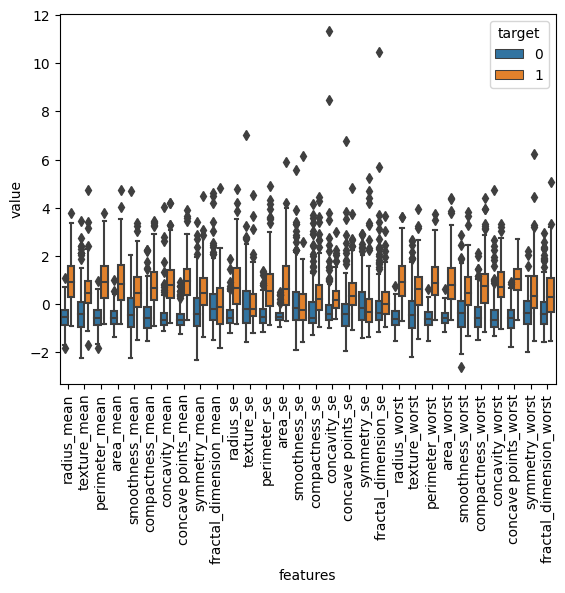

In [37]:
#X_train_df = pd.DataFrame(X_train, columns=columns)
#y_train = X_train_df["target"]
data_melted = pd.melt(X_train_df, id_vars = "target",
                     var_name = "features",
                      value_name = "value")
plt.figure()
sns.boxplot(x="features", y="value", hue="target", data=data_melted)
plt.xticks(rotation=90)
plt.show()

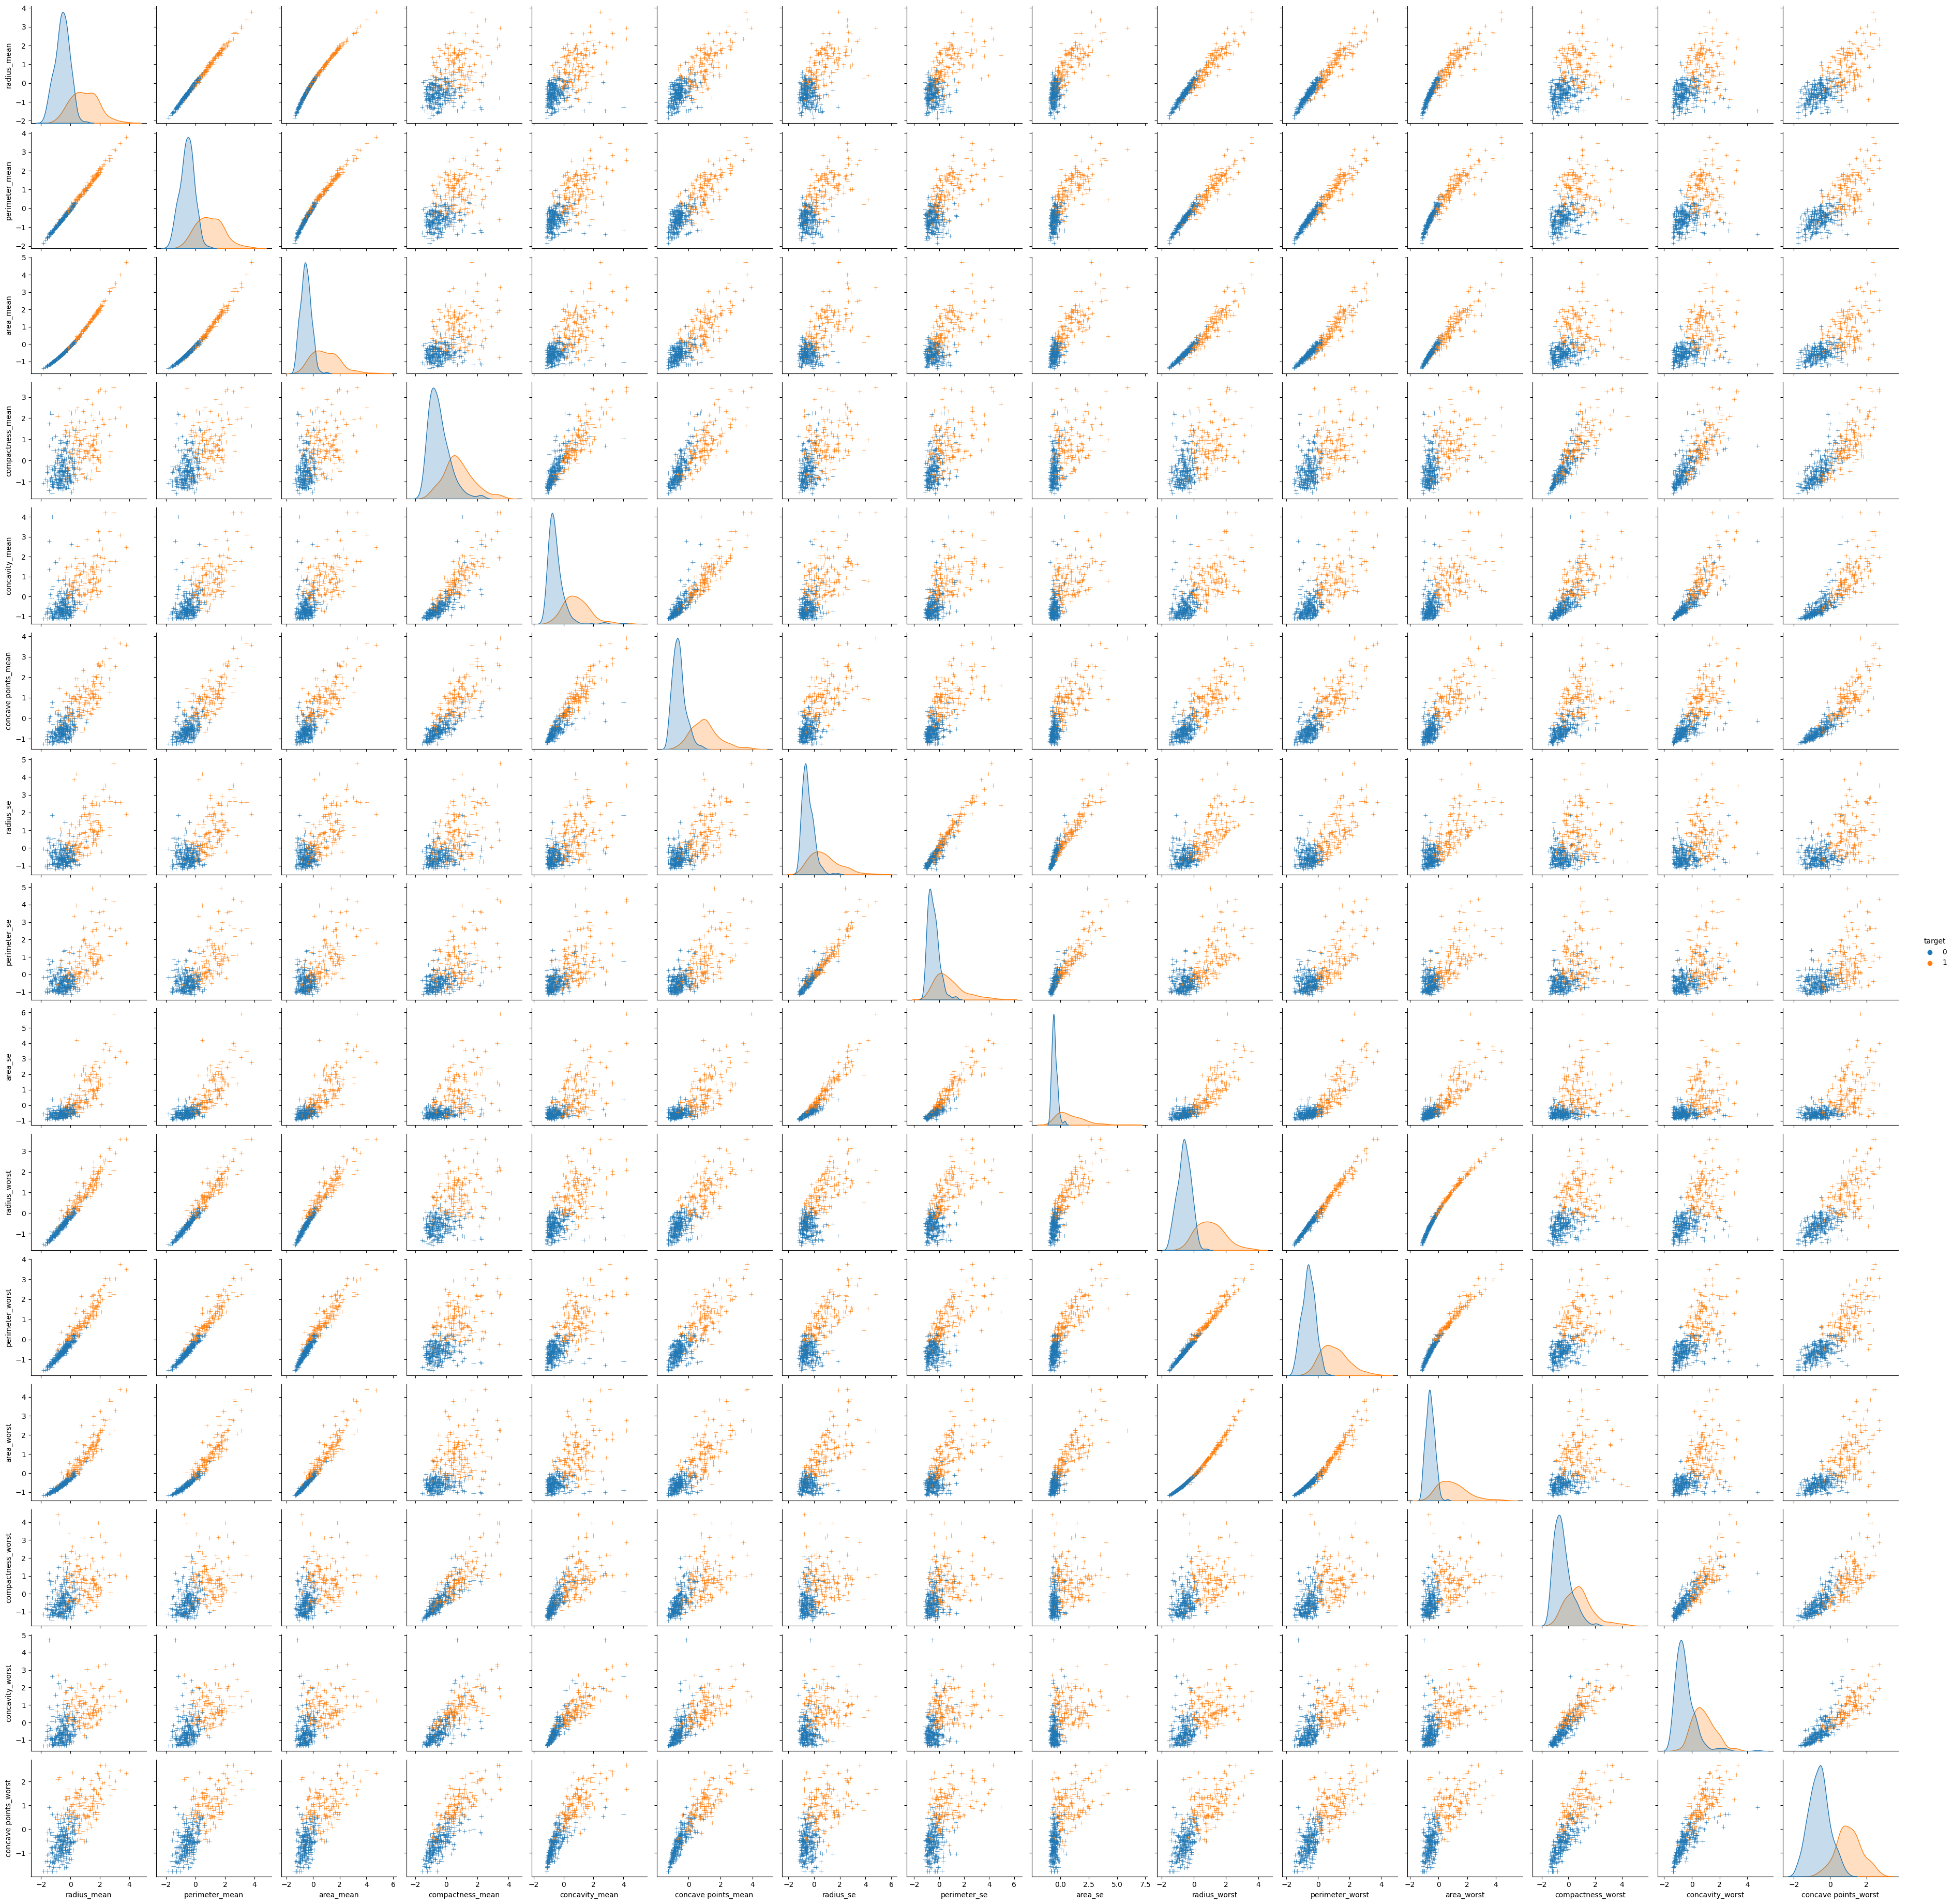

In [38]:
sns.pairplot(X_train_df[corr_features], diag_kind = "kde", markers="+", hue = "target")
plt.show()

### KNN
sensitive to outlier
big data da yavaş
curse of dimensionality
feature scaling
imbalance data da sıkıntı çıkarır

In [39]:
knn = KNeighborsClassifier(n_neighbors = 2)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
score = knn.score(X_test, y_test)
print("score :", score)
print("CM :", cm)
print("Basic KNN Accuracy :", acc)



score : 0.9529411764705882
CM : [[107   0]
 [  8  55]]
Basic KNN Accuracy : 0.9529411764705882


In [40]:
# iyi huyluların hepsi doğru, kötü huyluların 8 tanesi yanlış kaydedilmiş

* overfitting -- high variance
* underfitting -- high bias
* good balance -- low bias, low variance

### KNN best parameters

In [41]:
def KNN_Best_Params(x_train, x_test, y_train, y_test):
    k_range = list(range(1,31))
    weight_options = ["uniform", "distance"]
    print()
    param_grid = dict(n_neighbors = k_range, weights = weight_options)
    
    knn = KNeighborsClassifier()
    grid = GridSearchCV(knn, param_grid, cv=10, scoring="accuracy")
    grid.fit(x_train, y_train)
    print("Best training score : {} with parameters :{}".format(grid.best_score_, grid.best_params_))
    print()
    
    knn = KNeighborsClassifier(**grid.best_params_)
    knn.fit(x_train, y_train)
    
    y_pred_test = knn.predict(x_test)
    y_pred_train = knn.predict(x_train)
    
    cm_test = confusion_matrix(y_test, y_pred_test)
    cm_train = confusion_matrix(y_train, y_pred_train)
    
    acc_test = accuracy_score(y_test, y_pred_test)
    acc_train = accuracy_score(y_train, y_pred_train)
    print("Test Score : {}, Train Score : {}".format(acc_test, acc_train))
    print()
    print("CM Test:", cm_test)
    print("CM Train:", cm_train)
    return grid

grid = KNN_Best_Params(X_train, X_test, y_train, y_test)
    



Best training score : 0.9692948717948718 with parameters :{'n_neighbors': 4, 'weights': 'distance'}

Test Score : 0.9470588235294117, Train Score : 1.0

CM Test: [[104   3]
 [  6  57]]
CM Train: [[249   0]
 [  0 145]]


In [42]:
# overfitting problemi var --> train score %100, variance azaltılmaya çalışılmalı
# regularization veya model complexity azaltılmalı

### PCA, unsupervised
* mümkün olduğu kadar bilgi tutarak verinin boyutunun azaltılmasıdır
* birbirine yüksek corelasyonlu featurelar varsa onları çıkartabilir
* görselleştirmeyi kolaylaştırır, 30D --> 2D
* eigen vector, x - ~x(ort) = x 
*  eigen value, y - ~y(ort) = y ; bu sayede 0 merkezine çekilir
* cov(x,y)
* standardization

Text(0.5, 1.0, 'PCA : p1 vs p2')

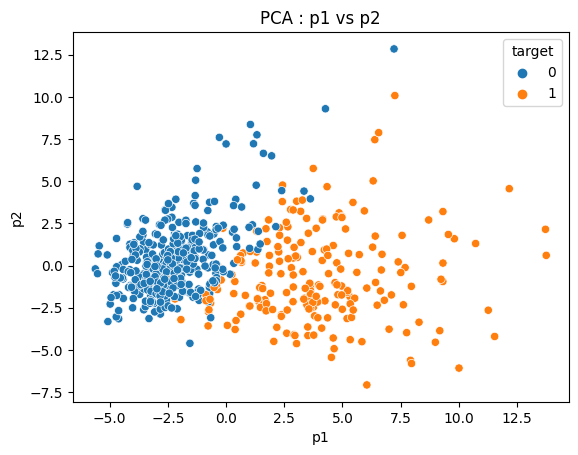

In [43]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
pca = PCA(n_components = 2)
pca.fit(x_scaled)
X_reduced_pca = pca.transform(x_scaled)
pca_data = pd.DataFrame(X_reduced_pca, columns = ["p1", "p2"])
pca_data["target"] = y
sns.scatterplot(x = "p1", y="p2", hue="target", data = pca_data)
plt.title("PCA : p1 vs p2")

In [44]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_reduced_pca, y, test_size=0.3, random_state=42)

In [45]:
grid_pca = KNN_Best_Params(X_train_pca, X_test_pca, y_train_pca, y_test_pca)


Best training score : 0.9593589743589742 with parameters :{'n_neighbors': 9, 'weights': 'uniform'}

Test Score : 0.9235294117647059, Train Score : 0.9593908629441624

CM Test: [[102   5]
 [  8  55]]
CM Train: [[243   6]
 [ 10 135]]


Text(0.5, 1.0, "2-Class classification (k = 9, weights = 'uniform')")

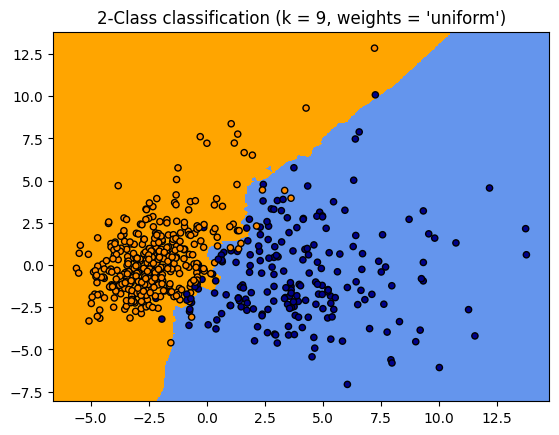

In [46]:
# visualize 
cmap_light = ListedColormap(['orange',  'cornflowerblue'])
cmap_bold = ListedColormap(['darkorange', 'darkblue'])

h = .05 # step size in the mesh
X = X_reduced_pca
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = grid_pca.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
            edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("%i-Class classification (k = %i, weights = '%s')"
          % (len(np.unique(y)),grid_pca.best_estimator_.n_neighbors, grid_pca.best_estimator_.weights))



### NCA

Text(0.5, 1.0, 'NCA: p1 vs p2')

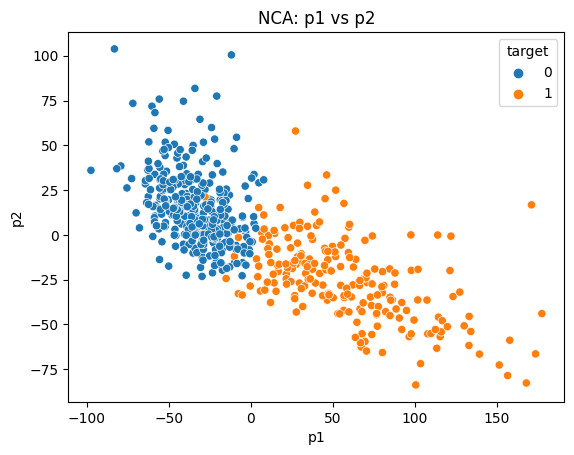

In [47]:
nca = NeighborhoodComponentsAnalysis(n_components = 2, random_state = 42)
nca.fit(x_scaled, y)
X_reduced_nca = nca.transform(x_scaled)
nca_data = pd.DataFrame(X_reduced_nca, columns = ["p1","p2"])
nca_data["target"] = y
sns.scatterplot(x = "p1",  y = "p2", hue = "target", data = nca_data)
plt.title("NCA: p1 vs p2")

In [48]:
X_train_nca, X_test_nca, y_train_nca, y_test_nca = train_test_split(X_reduced_nca, y, test_size=0.3, random_state=42)

In [49]:
grid_nca = KNN_Best_Params(X_train_nca, X_test_nca, y_train_nca, y_test_nca)


Best training score : 0.9949358974358974 with parameters :{'n_neighbors': 7, 'weights': 'distance'}

Test Score : 0.9705882352941176, Train Score : 1.0

CM Test: [[107   0]
 [  5  58]]
CM Train: [[249   0]
 [  0 145]]


Text(0.5, 1.0, "2-Class classification (k = 7, weights = 'distance')")

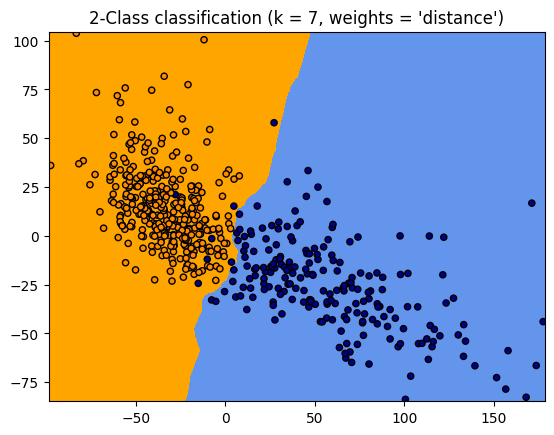

In [50]:
# visualize 
cmap_light = ListedColormap(['orange',  'cornflowerblue'])
cmap_bold = ListedColormap(['darkorange', 'darkblue'])

h = .2 # step size in the mesh
X = X_reduced_nca
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = grid_nca.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
            edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("%i-Class classification (k = %i, weights = '%s')"
          % (len(np.unique(y)),grid_nca.best_estimator_.n_neighbors, grid_nca.best_estimator_.weights))



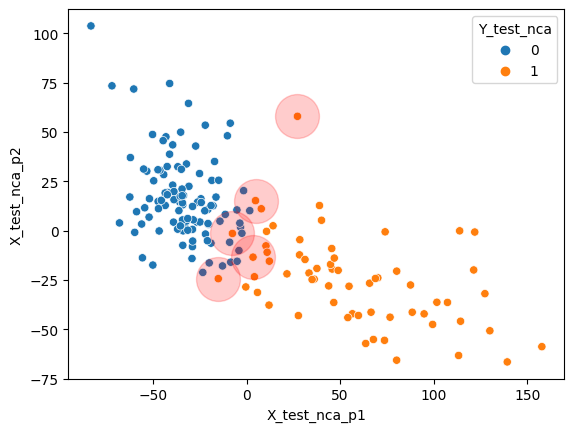

In [51]:
# %% find wrong decision
knn = KNeighborsClassifier(**grid_nca.best_params_)
knn.fit(X_train_nca,y_train_nca)
y_pred_nca = knn.predict(X_test_nca)
acc_test_nca = accuracy_score(y_pred_nca,y_test_nca)
knn.score(X_test_nca,y_test_nca)

test_data = pd.DataFrame()
test_data["X_test_nca_p1"] = X_test_nca[:,0]
test_data["X_test_nca_p2"] = X_test_nca[:,1]
test_data["y_pred_nca"] = y_pred_nca
test_data["Y_test_nca"] = y_test_nca

plt.figure()
sns.scatterplot(x="X_test_nca_p1", y="X_test_nca_p2", hue="Y_test_nca",data=test_data)

diff = np.where(y_pred_nca!=y_test_nca)[0]
plt.scatter(test_data.iloc[diff,0],test_data.iloc[diff,1],label = "Wrong Classified",alpha = 0.2,color = "red",s = 1000)


In [52]:
# train-test-split i değiştirmek sonuçları nasıl etkiler?